In [1]:
from lmfit import Model
import numpy as np
from scipy.integrate import dblquad,simpson
dbl_vec = np.vectorize(dblquad)
from astropy import units,constants
from matplotlib import pyplot as plt

In [3]:
data = np.loadtxt("/home/elijah-k2/Masters/Code/Rotation-Curves-master/Rotmass/Rotmass/NGC0247_rotmass.dat",unpack=True)

In [4]:
def disk_density(z,rbar,rho0,rd):
    zstar = 0.196*rd**0.633
    return rho0*np.exp(-rbar/rd)*(1-np.tanh(z/zstar)**2)

def surface_disk(rbar,rho0,rd):
    zstar = 0.196*rd**0.633
    return 2*rho0*np.exp(-rbar/rd)*zstar

def mass_disk(rmax,rho0,rd):
    integrand = lambda z,r: disk_density(z,r,rho0,rd)*2*np.pi*r
    z_set = np.linspace(np.zeros_like(rmax),rmax,num=51,axis=-1)
    r_h_set = np.sqrt(np.tensordot(rmax,np.ones(51),axes=0)**2 - z_set**2)
    r_set = np.linspace(np.zeros_like(r_h_set),r_h_set,num=51,axis=-1)
    z_mat = np.tensordot(z_set,np.ones(51),axes=0)
    return simpson(y=simpson(y=integrand(z_mat,r_set),x=r_set,axis=-1),x=z_set,axis=-1)


In [5]:
surface_model = Model(surface_disk,["rbar"],["rho0","rd"])
surface_model.set_param_hint("rho0",min=0.0,max=1e11)
surface_model.set_param_hint("rd",min=0.0,max=1e2)
result = surface_model.fit(data[7]*1e6,rbar=data[0],nan_policy='omit',method='nelder')
print(result.fit_report())

print(mass_disk(data[0],result.params['rho0'],result.params['rd']))

[[Model]]
    Model(surface_disk)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 269
    # data points      = 26
    # variables        = 2
    chi-square         = 3.3085e+13
    reduced chi-square = 1.3786e+12
    Akaike info crit   = 728.672501
    Bayesian info crit = 731.188694
    R-squared          = 0.99560660
[[Variables]]
    rho0:  93970545.3 +/- 2674692.52 (2.85%) (init = 0)
    rd:    3.67280105 +/- 0.07279010 (1.98%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho0, rd) = -0.9432
[1.10892090e+08 2.42242687e+08 4.04231371e+08 5.87365185e+08
 7.69846765e+08 9.66643359e+08 1.15907030e+09 1.34729774e+09
 1.52558661e+09 1.69898444e+09 1.86293776e+09 2.01403042e+09
 2.15765867e+09 2.29083175e+09 2.41588173e+09 2.52456003e+09
 2.62979725e+09 2.72385697e+09 2.80771618e+09 2.88502605e+09
 2.95461966e+09 3.01698203e+09 3.07161187e+09 3.12358259e+09
 3.16603215e+09 3.20321688e+09]


/tmp/ipykernel_35130/1064802366.py:7: RuntimeWarning: divide by zero encountered in divide
  return 2*rho0*np.exp(-rbar/rd)*zstar


[106.23195774 129.14949479 146.78698372 161.15993844 172.43726064
 182.5351935  191.01060805 198.33343692 204.59228823 210.17322725
 215.06989803 219.30399805 223.11343795 226.47920972 229.50859801
 232.04727245 234.42860823 236.49726215 238.29687314 239.92056606
 241.35452098 242.61811469 243.70903332 244.73342667 245.56070576
 246.27857312]


/tmp/ipykernel_35130/2773291402.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sqrt(a0*ab)*rbar*units.kpc.to('km'))


Parameters([('rho0', <Parameter 'rho0', value=<Parameter 'rho0', value=93970545.34827642 +/- 2.67e+06, bounds=[0.0:100000000000.0]> (fixed), bounds=[-inf:inf]>), ('rd', <Parameter 'rd', value=<Parameter 'rd', value=3.672801049772395 +/- 0.0728, bounds=[0.0:100.0]> (fixed), bounds=[-inf:inf]>), ('Q', <Parameter 'Q', value=0.2836781371555297 +/- 0.013, bounds=[0.0:100.0]>)])


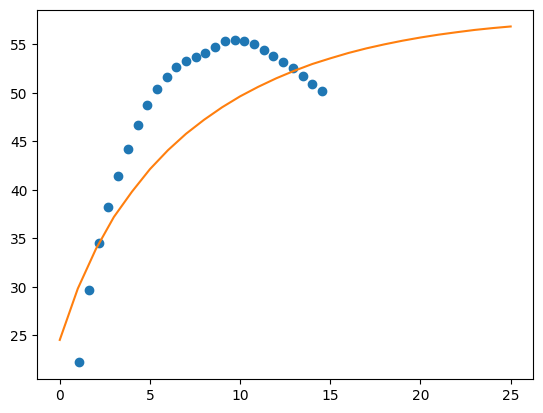

In [6]:
def v_disk(rbar,rho0,rd,Q):
    a0 = (1.9e-43*units.GeV/constants.hbar*constants.c).to('km/s^2').value
    ab = Q*mass_disk(rbar,rho0,rd)/rbar**2*constants.G.to('kpc^3/(Msun*s^2)').value*units.Unit('kpc/s^2').to('km/s^2')
    return np.sqrt(np.sqrt(a0*ab)*rbar*units.kpc.to('km'))

v_model = Model(v_disk,["rbar"],["rho0","rd","Q"])
v_model.set_param_hint("rho0",value=result.params['rho0'],vary=False)
v_model.set_param_hint("Q",min=0.0,max=1e2)
v_model.set_param_hint("rd",value=result.params['rd'],vary=False)

print(v_disk(data[0],result.params['rho0'],result.params['rd'],1e2))

v_fit = v_model.fit(data[4],rbar=data[0],method='nelder',nan_policy='omit')
print(v_fit.params)
plt.plot(data[0],data[4],linestyle="none",marker="o")
plt.plot(v_disk(data[0],result.params['rho0'],result.params['rd'],v_fit.params['Q']))
plt.show()